In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        '''
        Returns:
        next_state:下一个状态, 标量
        reward:奖励, 标量
        '''
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [2]:
class DynaQ:
    """ Dyna-Q算法 """
    def __init__(self,
                 ncol,
                 nrow,
                 epsilon,
                 alpha,
                 gamma,
                 n_planning,
                 n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.n_planning = n_planning  #执行Q-planning的次数, 对应1次Q-learning
        self.model = dict()  # 环境模型

    def take_action(self, state):  # 选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action) # explore
        else:
            action = np.argmax(self.Q_table[state]) # exploit
        return action

    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0, a0, r, s1):
        self.q_learning(s0, a0, r, s1)
        #? ----------------- Q-planning ----------------- #
        self.model[(s0, a0)] = r, s1  # 将数据添加到模型中
        for _ in range(self.n_planning):  # Q-planning循环
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)

In [3]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少幕

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2999.72it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1764.34it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 262.91it/s, episode=300, return=-13.400]


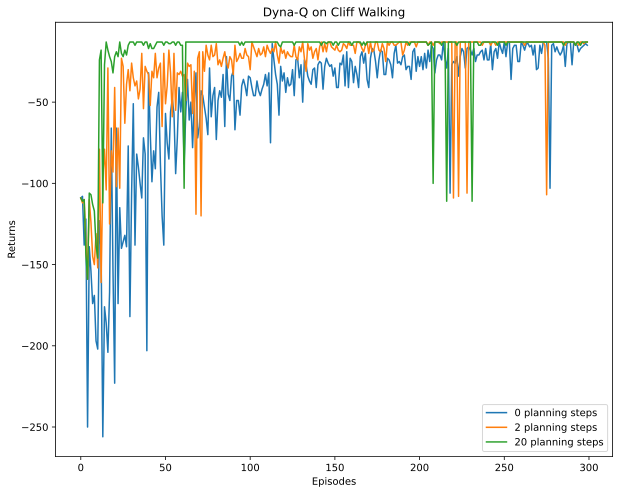

In [10]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]

plt.figure(figsize=(10, 8))
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')

# %config InlineBackend.figure_format='svg'

plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
# plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.show()

# Q-planning步数为：0

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 615.42it/s, episode=30,
# return=-138.400]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 1079.50it/s, episode=60,
# return=-64.100]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 1303.35it/s, episode=90,
# return=-46.000]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 1169.51it/s, episode=120,
# return=-38.000]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 1806.96it/s, episode=150,
# return=-28.600]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 2303.21it/s, episode=180,
# return=-25.300]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 2473.64it/s, episode=210,
# return=-23.600]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 2344.37it/s, episode=240,
# return=-20.100]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 1735.84it/s, episode=270,
# return=-17.100]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2827.94it/s, episode=300,
# return=-16.500]

# Q-planning步数为：2

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 425.09it/s, episode=30,
# return=-53.800]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 655.71it/s, episode=60,
# return=-37.100]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 799.69it/s, episode=90,
# return=-23.600]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 915.34it/s, episode=120,
# return=-18.500]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 1120.39it/s, episode=150,
# return=-16.400]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 1437.24it/s, episode=180,
# return=-16.400]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 1366.79it/s, episode=210,
# return=-13.400]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 1457.62it/s, episode=240,
# return=-13.200]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 1743.68it/s, episode=270,
# return=-13.200]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1699.59it/s, episode=300,
# return=-13.500]

# Q-planning步数为：20

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 143.91it/s, episode=30,
# return=-18.500]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 268.53it/s, episode=60,
# return=-13.600]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 274.53it/s, episode=90,
# return=-13.000]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 264.25it/s, episode=120,
# return=-13.500]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 263.58it/s, episode=150,
# return=-13.500]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 245.27it/s, episode=180,
# return=-13.000]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 257.16it/s, episode=210,
# return=-22.000]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 257.08it/s, episode=240,
# return=-23.200]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 261.12it/s, episode=270,
# return=-13.000]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 213.01it/s, episode=300,
# return=-13.400]

In [12]:
model  = dict()
model[(0, 0)] = 0, 0
print(model)

{(0, 0): (0, 0)}


In [13]:
model.items()

dict_items([((0, 0), (0, 0))])

In [17]:
(a, b), (c, d) = list(model.items())[0]

In [19]:
print(a)

0
